In [90]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

import contextily as ctx

In [91]:
districts = gpd.read_file("data7/communities.json")
addresses = pd.read_csv("data7/addressregisterlviv17102025.csv", sep=";", encoding="utf-8")
settlements = pd.read_excel("data7/np.xlsx")
traffic = pd.read_excel("data7/obsagtrafiku.xlsx")
mobility = pd.read_excel("data7/perem.xlsx")
build_hist_lviv = gpd.read_file("data7/build_hist_lviv_geojson_2025-10-29.geojson")
stats = pd.read_excel("data7/stetsifika.xlsx")

### Exersice 1: POI counts per city district

In [92]:
print(districts.head())

    n                  name                                           geometry
0  15            Левандівка  MULTIPOLYGON (((23.98024 49.85298, 23.98176 49...
1  39                Щурата  MULTIPOLYGON (((24.03262 49.88127, 24.03738 49...
2  29   Сигнівка-Сріблястий  MULTIPOLYGON (((23.94703 49.82478, 23.94729 49...
3   9               Голоско  MULTIPOLYGON (((24.01633 49.86762, 24.0154 49....
4  36  Топольна-Замарстинів  MULTIPOLYGON (((24.01894 49.86752, 24.01633 49...


In [93]:
print(build_hist_lviv.head())

              address      name_build    date_build num_ohor_build  \
0   ген. Грицая Д. 10           вілла  30-ті XX ст.           2577   
1  ген. Грицая Д. 11а           вілла  30-ті XX ст.           2579   
2       Краківська 28      житл. буд.  кін. XIX ст.            962   
3       Краківська 26      житл. буд.  кін. XIX ст.            962   
4       Краківська 34  житл.-адм.буд.       XIX ст.           2121   

               moid                                               geom  note  \
0  9505408688925804  { "type": "Point", "coordinates": [ 24.0473771...  None   
1  9505408688925806                                               None  None   
2  9505408688926222                                               None  None   
3  9505408688926221  { "type": "Point", "coordinates": [ 24.0298395...  None   
4  9505408688926223  { "type": "Point", "coordinates": [ 24.0296934...  None   

  editor_id   uid editor_date                   geometry  
0      None  None        None    POINT 

In [94]:
build_hist_lviv = build_hist_lviv[build_hist_lviv.geometry.notnull()] #прибираєм пусті геометрії
print(build_hist_lviv.head())

             address                                         name_build  \
0  ген. Грицая Д. 10                                              вілла   
3      Краківська 26                                         житл. буд.   
4      Краківська 34                                     житл.-адм.буд.   
5     Кривоноса М. 1  монастир школа міліції (монастир о.реформаторі...   
6     Кривоноса М. 6                                   колегія Театинів   

      date_build num_ohor_build              moid  \
0   30-ті XX ст.           2577  9505408688925804   
3   кін. XIX ст.            962  9505408688926221   
4        XIX ст.           2121  9505408688926223   
5  1656-1664 рр.            139  9505408688926230   
6  1738-1745 рр.            603  9505408688926231   

                                                geom  note editor_id   uid  \
0  { "type": "Point", "coordinates": [ 24.0473771...  None      None  None   
3  { "type": "Point", "coordinates": [ 24.0298395...  None      None  None

In [95]:
joined = gpd.sjoin(build_hist_lviv, districts, how="left", predicate="within")#поєднюєм райони і памятки

In [96]:
poi_counts = joined.groupby("name")["geometry"].count().reset_index()#рахуємо к-сть
poi_counts.columns = ["name", "poi_count"]

In [97]:
districts_poi = districts.merge(poi_counts, on="name", how="left") #додаєм лічиотники до регіонів
districts_poi["poi_count"] = districts_poi["poi_count"].fillna(0)

/var/folders/y3/dmv00y2165gfpng1rhr5sdrm0000gn/T/ipykernel_95031/1812253877.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  districts_poi["coords"] = districts_poi["geometry"].centroid


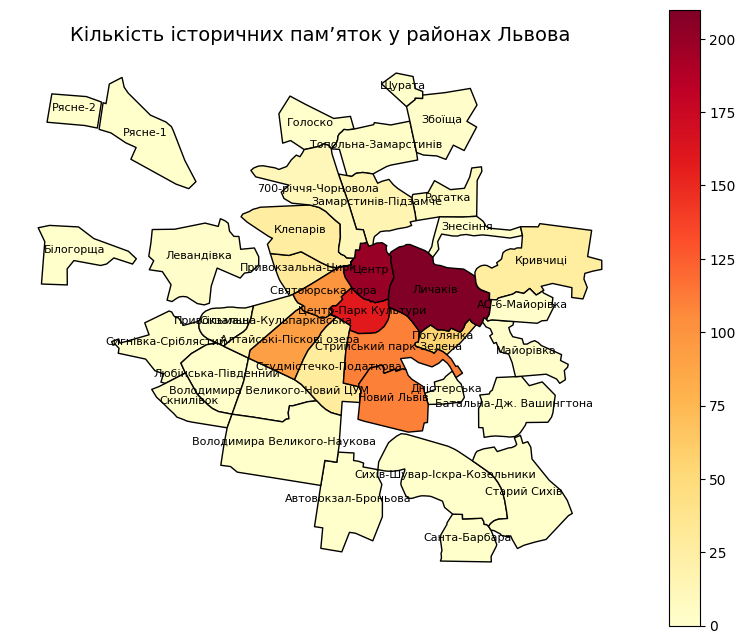

In [98]:
fig, ax = plt.subplots(figsize=(10, 8))
districts_poi.plot(column="poi_count", cmap="YlOrRd", legend=True, edgecolor="black", ax=ax)
plt.title("Кількість історичних пам’яток у районах Львова", fontsize=14)
plt.axis("off")

districts_poi["coords"] = districts_poi["geometry"].centroid
for _, row in districts_poi.iterrows():
    plt.text(row["coords"].x, row["coords"].y, row["name"], fontsize=8, ha="center")

plt.show()

### Exersice 2:distances from each city address to closest POI. Describe stats.

In [99]:
addresses.head()

,address_id,house_id,post_index,vpz_ua,city_name,district_name,scode,street_type,street_d_name,street_s_name,housenumber,pavilion,u_adr,change_doc_date,change_doc_state,x,y,comment_location_address,codifier2021,KOATUU
0,27732,692955f1-9a70-11ea-a29c-00155d153f03,79053.0,Львів 53,Львів,Франківський район,2283,вулиця,Янева В.,В. Янева,23,NaN,2283_23_,2019-11-08,656,24.011755,49.810906,NaN,UA46060250010015970,4610100000
1,18487,d14758ca-453a-11e7-b7ff-00155d153f03,79054.0,Львів 54,Львів,Залізничний район,1841,вулиця,Петлюри С.,С. Петлюри,22,NaN,1841_22_,NaN,NaN,23.978172,49.820649,NaN,UA46060250010015970,4610100000
2,18197,a738ff4f-453a-11e7-b0df-00155d153f03,79008.0,Львів 8,Львів,Галицький район,1935,площа,"Ринок, пл.",Ринок,34,NaN,1935_34_,NaN,NaN,24.030700,49.842332,NaN,UA46060250010015970,4610100000
3,27226,ae9e14f3-453a-11e7-9b00-00155d153f03,79017.0,Львів 17,Львів,Личаківський район,2030,вулиця,Сліпого Й.,Й. Сліпого,31а,NaN,2030_31а_,2018-02-22,NaN,24.041479,49.829196,NaN,UA46060250010015970,4610100000
4,19526,902349ad-453a-11e7-abb4-00155d153f03,79052.0,Львів 52,Львів,Залізничний район,1162,вулиця,Вигоди,Вигоди,46,NaN,1162_46_,NaN,NaN,23.973358,49.840043,NaN,UA46060250010015970,4610100000


In [100]:
addresses_gdf = gpd.GeoDataFrame(
    addresses,
    geometry=gpd.points_from_xy(addresses["x"], addresses["y"]),
    crs="EPSG:4326" 
)#перетворюєм в геодатфрейм
addresses_gdf.head()

,address_id,house_id,post_index,vpz_ua,city_name,district_name,scode,street_type,street_d_name,street_s_name,...,pavilion,u_adr,change_doc_date,change_doc_state,x,y,comment_location_address,codifier2021,KOATUU,geometry
0,27732,692955f1-9a70-11ea-a29c-00155d153f03,79053.0,Львів 53,Львів,Франківський район,2283,вулиця,Янева В.,В. Янева,...,NaN,2283_23_,2019-11-08,656,24.011755,49.810906,NaN,UA46060250010015970,4610100000,POINT (24.01176 49.81091)
1,18487,d14758ca-453a-11e7-b7ff-00155d153f03,79054.0,Львів 54,Львів,Залізничний район,1841,вулиця,Петлюри С.,С. Петлюри,...,NaN,1841_22_,NaN,NaN,23.978172,49.820649,NaN,UA46060250010015970,4610100000,POINT (23.97817 49.82065)
2,18197,a738ff4f-453a-11e7-b0df-00155d153f03,79008.0,Львів 8,Львів,Галицький район,1935,площа,"Ринок, пл.",Ринок,...,NaN,1935_34_,NaN,NaN,24.030700,49.842332,NaN,UA46060250010015970,4610100000,POINT (24.0307 49.84233)
3,27226,ae9e14f3-453a-11e7-9b00-00155d153f03,79017.0,Львів 17,Львів,Личаківський район,2030,вулиця,Сліпого Й.,Й. Сліпого,...,NaN,2030_31а_,2018-02-22,NaN,24.041479,49.829196,NaN,UA46060250010015970,4610100000,POINT (24.04148 49.8292)
4,19526,902349ad-453a-11e7-abb4-00155d153f03,79052.0,Львів 52,Львів,Залізничний район,1162,вулиця,Вигоди,Вигоди,...,NaN,1162_46_,NaN,NaN,23.973358,49.840043,NaN,UA46060250010015970,4610100000,POINT (23.97336 49.84004)


In [102]:
joined = gpd.sjoin_nearest(addresses_proj, build_hist_proj, distance_col="dist_to_POI_m") #знаходимо найближчого сусіда

In [103]:
joined.head(3)

,address_id,house_id,post_index,vpz_ua,city_name,district_name,scode,street_type,street_d_name,street_s_name,...,name_build,date_build,num_ohor_build,moid,geom,note,editor_id,uid,editor_date,dist_to_POI_m
0,27732,692955f1-9a70-11ea-a29c-00155d153f03,79053.0,Львів 53,Львів,Франківський район,2283,вулиця,Янева В.,В. Янева,...,вілла,20-ті XX ст.,2684,9505408689319810,"{ ""type"": ""Point"", ""coordinates"": [ 24.0262424...",None,None,None,None,1223.587227
1,18487,d14758ca-453a-11e7-b7ff-00155d153f03,79054.0,Львів 54,Львів,Залізничний район,1841,вулиця,Петлюри С.,С. Петлюри,...,обласна психіатрична лікарня (лікарня),1870-1875 рр.,1618,9505408688926275,"{ ""type"": ""Point"", ""coordinates"": [ 23.9912331...",None,None,None,None,1033.579534
2,18197,a738ff4f-453a-11e7-b0df-00155d153f03,79008.0,Львів 8,Львів,Галицький район,1935,площа,"Ринок, пл.",Ринок,...,житл. буд. (житл. буд. кам’яниця Вільчків),поч. XIX ст.,321,9505408689188831,"{ ""type"": ""Point"", ""coordinates"": [ 24.0308345...",None,None,None,None,71.444910


In [104]:
print(joined["dist_to_POI_m"].describe())

count    29546.000000
mean       971.407476
std       1131.718890
min          0.217669
25%        115.445780
50%        528.202412
75%       1359.031441
max       5351.630974
Name: dist_to_POI_m, dtype: float64


### Exersice 3: visualize 20 most common source locations for visitors (Mobility dataset)

In [109]:
print(mobility.head())

   ID_homecity home_district homecity  homecity_latitude  homecity_longitude  \
0          101       Буський    Буськ          49.966967           24.613881   
1          101       Буський    Буськ          49.966967           24.613881   
2          101       Буський    Буськ          49.966967           24.613881   
3          101       Буський    Буськ          49.966967           24.613881   
4          101       Буський    Буськ          49.966967           24.613881   

   ID_lvivpoint                              lvivpoint  lvivpoint_latitude  \
0             1            Автовокзал (вул. Стрийська)           49.786755   
1             2  Автостанція №2 (вул. Б.Хмельницького)           49.864318   
2             3          Автостанція №3 (вул. Петлюри)           49.823695   
3             4         Автостанція №4 (вул. Шевченка)           49.850002   
4             5           Автостанція №5 (вул. Зелена)           49.807069   

   lvivpoint_longitude                 lvivpoint_t

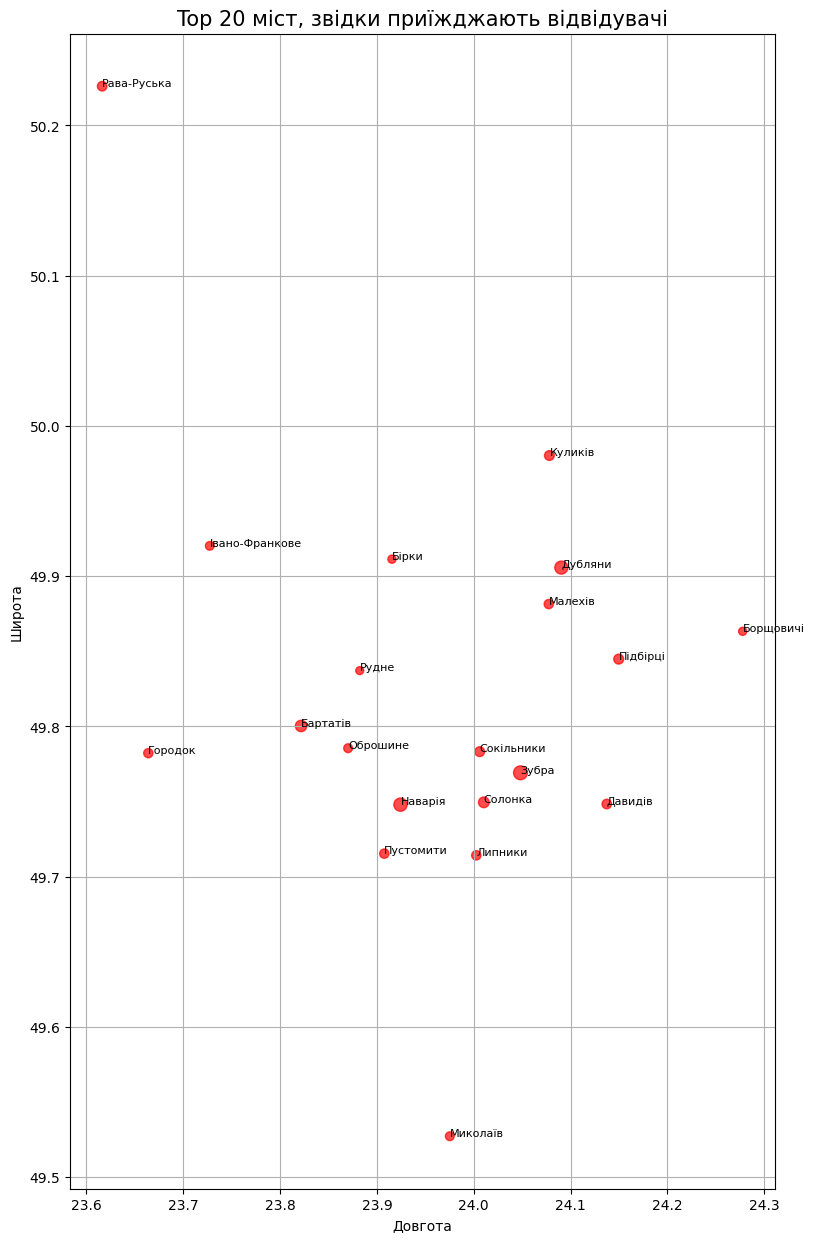

In [110]:
top_cities = (
    mobility.groupby(["homecity", "homecity_latitude", "homecity_longitude"])["amount"]
    .sum()
    .reset_index()
    .sort_values("amount", ascending=False)
    .head(20)
)

top_cities_gdf = gpd.GeoDataFrame(
    top_cities,
    geometry=gpd.points_from_xy(top_cities["homecity_longitude"], top_cities["homecity_latitude"]),
    crs="EPSG:4326"
)#створюємо геодатафрейм


fig, ax = plt.subplots(figsize=(15, 15))#зоображаєм

top_cities_gdf.plot(
    ax=ax,
    color="red",
    markersize=top_cities_gdf["amount"] / top_cities_gdf["amount"].max() * 100,
    alpha=0.7
)

for idx, row in top_cities_gdf.iterrows():
    plt.text(
        row.geometry.x,
        row.geometry.y,
        row["homecity"],
        fontsize=8
    )

plt.title("Top 20 міст, звідки приїжджають відвідувачі", fontsize=15)
plt.xlabel("Довгота")
plt.ylabel("Широта")
plt.grid(True)
plt.show()

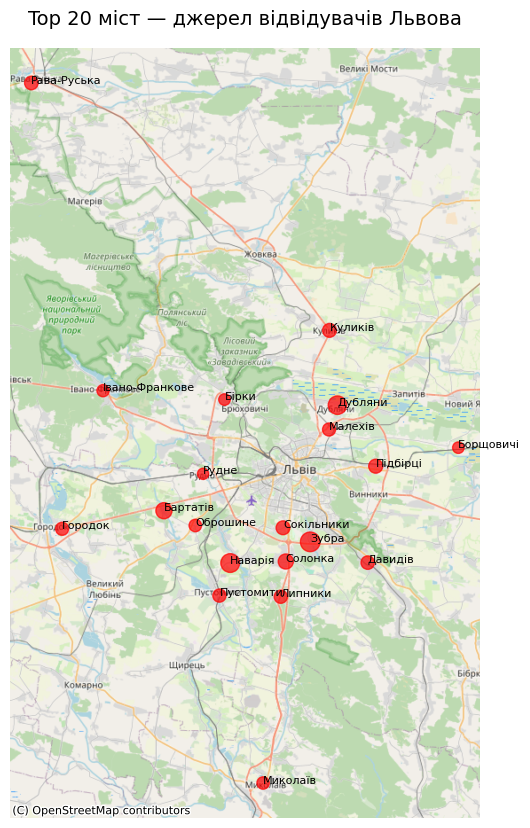

In [111]:
top_cities_web = top_cities_gdf.to_crs(epsg=3857)#переводимо у метричну систему 

fig, ax = plt.subplots(figsize=(10, 10))#зоображаєм
top_cities_web.plot(
    ax=ax,
    color="red",
    markersize=top_cities_web["amount"] / top_cities_web["amount"].max() * 200,
    alpha=0.7
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)#додаємо опен стріт меп

for idx, row in top_cities_web.iterrows():
    ax.text(
        row.geometry.x,
        row.geometry.y,
        row["homecity"],
        fontsize=8,
        color="black"
    )

ax.set_title("Top 20 міст — джерел відвідувачів Львова", fontsize=14)
ax.set_axis_off()
plt.show()

### Exercise 4: average distance traveled (Mobility dataset)

In [117]:
home_points = gpd.GeoDataFrame(
    mobility,
    geometry=gpd.points_from_xy(mobility.homecity_longitude, mobility.homecity_latitude),
    crs="EPSG:4326"
)#створюєм геодатафрейм міста

lviv_points = gpd.GeoDataFrame(
    mobility,
    geometry=gpd.points_from_xy(mobility.lvivpoint_longitude, mobility.lvivpoint_latitude),
    crs="EPSG:4326"
)#гд Львову

home_points = home_points.to_crs(epsg=32634)#перетворюєм у метричну систему координат
lviv_points = lviv_points.to_crs(epsg=32634)#тут теж

mobility["distance_m"] = home_points.geometry.distance(lviv_points.geometry)#розраховуєм в метрах

avg_distance = mobility["distance_m"].mean()#середня відстань

print(f"Середня відстань, яку долають відвідувачі: {avg_distance/1000:.2f} км")

Середня відстань, яку долають відвідувачі: 31.86 км


In [118]:
print(mobility["distance_m"].describe())

count     2692.000000
mean     31856.470108
std      15777.177413
min        187.766993
25%      18237.413615
50%      32169.633967
75%      44681.051907
max      68719.957493
Name: distance_m, dtype: float64
